In [1]:
import pickle
import glob
import cv2
import pde
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from matplotlib import colors
from tqdm import tqdm
from TippingFPE import TippingPDE

This script redos the FPE analysis with the results integrated from uniform initial conditions

In [2]:
extent = (-2.5, 2.5)
shape  = 150

print(f"WARNING: grid is hardcoded to extent ({extent}, {extent}) and resolution ({shape}, {shape})")

state_probabilities = []

# probability threshold
tau = 0.05

# set up the blob detector
detector_params = cv2.SimpleBlobDetector_Params()
detector_params.minArea = 10
detector = cv2.SimpleBlobDetector_create(detector_params)

def contour_center_of_mass(contour):
    contour = np.array(contour).squeeze()
    return contour.mean(axis=0)

for i, file in enumerate(tqdm(glob.glob("../data.nosync/FPE/binary_noise0p2_uniform/*.pkl"))):
    with open(file, "rb") as file:
            
        # load simulation results
        coupling_matrix, p, info = pickle.load(file)
            
        # threshold the probability density to retrieve a binary image for contour detection
        p_thresh = np.array(p > tau*p.max(), dtype=np.uint8)
        # find contours corresponding to each state
        contours, _ = cv2.findContours(p_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # calculate probability for each state by masking the probability density 
        contour_probabilities = [(p*np.array(cv2.fillPoly(np.zeros_like(p), pts=[contour], color=1))).sum()/p.sum() for contour in contours]
        # calculate centroids for the contours 
        contour_centroids = [contour_center_of_mass(contour) - shape/2 for contour in contours]

        # @David you should have done this during simulation, you idiot
        grid  = pde.CartesianGrid(2*(extent,), 2*(shape,))
        state = pde.ScalarField(grid, p)
        eq    = TippingPDE(grid, coupling_matrix, noise_level=0.2)
        # calculate the state probabilities
        statistics = eq.state_probability(state)
        # runtime
        runtime = pd.Timedelta(info["controller"]["solver_duration"]).total_seconds()

        # calculate number of contours based on the quadrant state probabilities
        quad_n_states = np.sum(np.array(statistics) > tau)

        state_probabilities.append([coupling_matrix[0, 1], coupling_matrix[1, 0], quad_n_states, len(contours), contour_probabilities, contour_centroids, p, runtime, info["controller"]["stop_reason"]])

state_probabilities = pd.DataFrame(state_probabilities)
state_probabilities.columns = ["dxy", "dyx", "quad_n_states", "ocv_n_states", "ocv_p_states", "ocv_r_states", "p", "runtime", "stop_reason"]

state_probabilities_err = state_probabilities[state_probabilities.stop_reason != "Reached final time"]

# numerical instable simulations
# drop samples where the detected number of states is > 4 indicating artefacts in the probability density
print(f"Before Filtering: {len(state_probabilities)}")
state_probabilities = state_probabilities[state_probabilities.ocv_n_states <= 4]
state_probabilities = state_probabilities[state_probabilities.stop_reason == "Reached final time"]
print(f"After  Filtering: {len(state_probabilities)}")

100%|██████████| 2492/2492 [00:06<00:00, 374.54it/s]

Before Filtering: 2492
After  Filtering: 2490


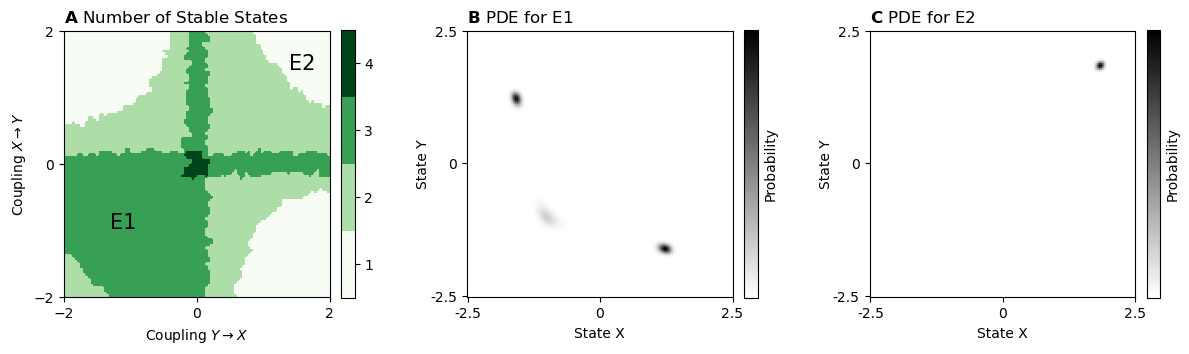

In [3]:
dxy = dyx = np.linspace(-2, 2, 100)
dxy,  dyx = np.meshgrid(dxy, dyx)

grid = sp.interpolate.griddata(state_probabilities.iloc[:,0:2], state_probabilities.quad_n_states, (dxy, dyx), method="nearest")

plt.figure(figsize=(12, 4))

idxs = [600, 1877]

plt.subplot(131)
plt.imshow(grid, origin="lower", cmap=plt.get_cmap('Greens', 4), extent=(-2, 2, -2, 2), vmin=1 - 0.5, vmax=4 + 0.5)
plt.colorbar(ticks=np.arange(1, 5), fraction=0.046, pad=0.04)

# plt.scatter(state_probabilities_err.dxy, state_probabilities_err.dyx, color="purple", s=1)
[plt.text(state_probabilities.iloc[idx].dxy, state_probabilities.iloc[idx].dyx, ["E1", "E2"][i], color="black", fontsize=15, ha="center", va="bottom" if i == 0 else "center") for i, idx in enumerate(idxs)]

plt.title(r"$\bf{A}$ Number of Stable States", x=0, ha="left")
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.xlabel(r"Coupling $Y \rightarrow X$")
plt.ylabel(r"Coupling $X \rightarrow Y$")

for i, idx in enumerate(idxs):
    plt.subplot(132 + i)
    im = plt.imshow(state_probabilities.iloc[idx].p, cmap="binary", origin="lower")
    plt.title(r"$\bf{" + ["B", "C"][i] + "}$ PDE for " + ["E1", "E2"][i], ha="left", x=0)
    plt.xlabel("State X")
    plt.ylabel("State Y", labelpad=0)
    plt.xticks([0, 75, 150], [-2.5, 0, 2.5])
    plt.yticks([0, 75, 150], [-2.5, 0, 2.5])
    cbar = plt.colorbar(ticks=[], label="Probability", fraction=0.046, pad=0.04)

plt.tight_layout(w_pad=3)
plt.savefig("../plots/FPE_binary_noise0p2.png", bbox_inches="tight", dpi=200)
plt.show()

In [4]:
df = state_probabilities.explode(["ocv_p_states", "ocv_r_states"])
df = df[df.ocv_r_states.map(lambda x: type(x) == np.ndarray)]
df["state"] = df.ocv_r_states.apply(lambda x: (x[0] > 0) + 2*(x[1] > 0))

df_most_probable = df.groupby(["dxy", "dyx"]).apply(lambda x:  x.state.iloc[np.argmax(x.ocv_p_states)]).reset_index()

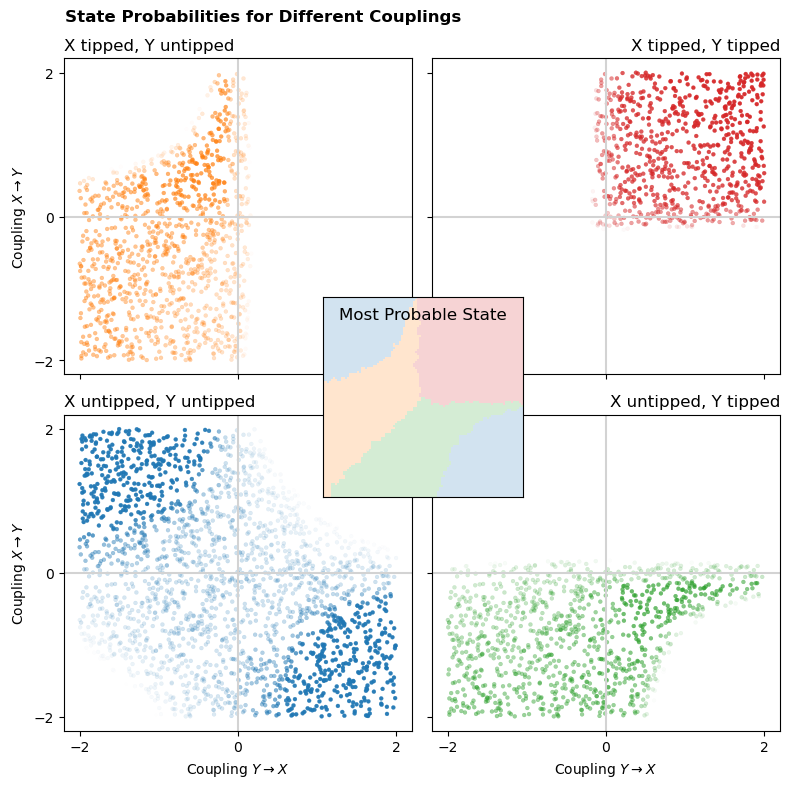

In [28]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))

axs[0, 0], axs[1, 1] = axs[1, 1], axs[0, 0]

states = {}
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        state = 2*(1 - i) + j # the state numbering is so that it fits with the one in the above cell and quadrants are properly placed
        
        # state description
        state_desc = f"{2*j - 1} {1 - 2*i}"
        states[state] = state_desc

        df_plot = df[df.state == state].copy()
        sns.scatterplot(data=df_plot, x="dxy", y="dyx", alpha=df_plot.ocv_p_states.clip(0, 1), ax=ax, legend=False, edgecolors=None, color=f"C{state}", s=8)
        
        ax.set_title(["X untipped", "X tipped"][j] + ", " + ["Y tipped", "Y untipped"][i], x=0 if i==1 else 1, ha="left" if i==1 else "right")
        ax.axvline(0, color="lightgray")
        ax.axhline(0, color="lightgray")
        ax.set_xticks([-2, 0, 2])
        ax.set_yticks([-2, 0, 2])
        ax.set_xlabel(r"Coupling $Y \rightarrow X$")
        ax.set_ylabel(r"Coupling $X \rightarrow Y$")

plt.suptitle("State Probabilities for Different Couplings", x=0.088, ha="left", fontweight="bold")
plt.tight_layout()

# inset most probable state
#ax = axs[0, 0].inset_axes([0.535 - 0.125, 0.53 - 0.125, 0.25, 0.25], transform=plt.gcf().transFigure)
ax = plt.gcf().add_axes([0.535 - 0.125, 0.495 - 0.125, 0.25, 0.25])
ax.set_xticks([])
ax.set_yticks([])

cmap = colors.ListedColormap([f"C{i}" for i in range(4)])
grid = sp.interpolate.griddata(df_most_probable.iloc[:,0:2], df_most_probable.iloc[:,2], (dxy, dyx), method="nearest")
ax.imshow(grid, origin="lower", extent=(-2, 2, -2, 2), cmap=cmap, alpha=0.2)
ax.set_title("Most Probable State", y=0.85)

plt.savefig("../plots/FPE_binary_noise0p2_state_probabilities.png", bbox_inches="tight", dpi=200)
plt.show()

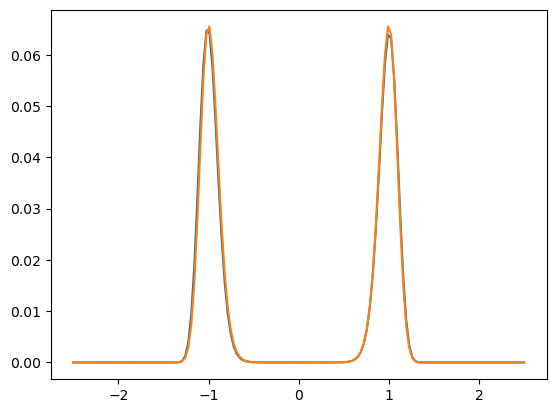

dxy                                                      -0.005637
dyx                                                        0.01252
quad_n_states                                                    4
ocv_n_states                                                     4
ocv_p_states     [0.2330864683695658, 0.238356209586552, 0.2376...
ocv_r_states     [[-29.487804878048777, 29.024390243902445], [2...
p                [[-5.934811991578294e-10, 1.4261663317646151e-...
dp_max                                                    0.005811
stop_reason                                     Reached final time
Name: 44, dtype: object

In [114]:
# check that the dxy = dyx = 0 solution is consistent with the analytical solution for a noise level of 0.1

idx = ((state_probabilities.dxy**2 + state_probabilities.dyx**2)**0.5).argmin()
p   = state_probabilities.iloc[idx].p
p /= p.sum()

x = np.linspace(-2.5, 2.5, shape)
pa = np.exp(-4*(x**4/4 - x**2/2)/(2*0.2**2))

plt.plot(x, p.sum(axis=1))
plt.plot(x, pa/pa.sum())
plt.show()

state_probabilities.iloc[idx]


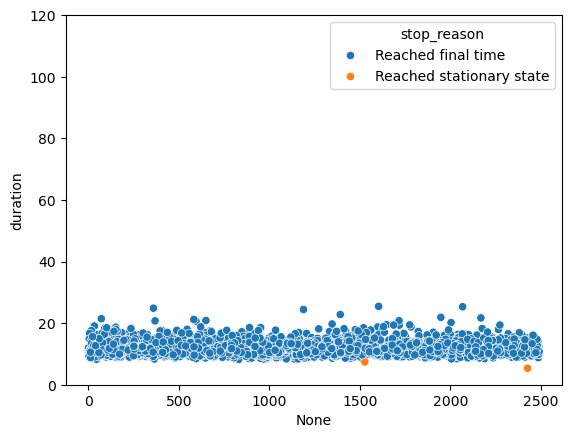

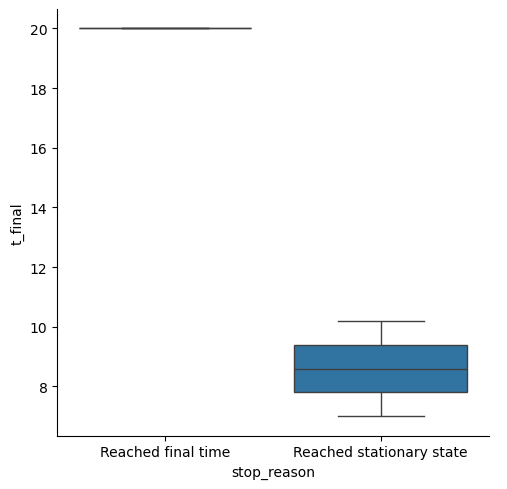

In [118]:
from datetime import datetime, timedelta 

res = []
for i, file in enumerate(glob.glob("../data.nosync/FPE/binary_noise0p2_uniform/*.pkl")):
    with open(file, "rb") as file:
            
        # load simulation results
        coupling_matrix, p, info = pickle.load(file)
        res.append([info["controller"]["solver_start"], info["controller"]["solver_duration"], info["controller"]["stop_reason"], info["controller"]["t_final"]])

    
res = pd.DataFrame(res, columns=["start", "duration", "stop_reason", "t_final"])
res["start"] = pd.to_datetime(res["start"])
res["duration"] = pd.to_timedelta(res["duration"]).apply(lambda x: x.total_seconds())
res = res.sort_values(by="start") 

sns.scatterplot(res, x=res.index, y="duration", hue="stop_reason")
plt.ylim(0, 120)
plt.show()

sns.catplot(res, x=res.stop_reason, y="t_final", kind="box")
plt.show()

In [121]:
from ipywidgets import interact

grid = sp.interpolate.griddata(state_probabilities.iloc[:,0:2], state_probabilities.quad_n_states, (dxy, dyx), method="nearest")

@interact(dxy=(-2.5, 2.5, 0.1), dyx=(-2.5, 2.5, 0.1))
def plot(dxy, dyx):
    idx = ((state_probabilities.dxy - dxy)**2 + (state_probabilities.dyx - dyx)**2).argmin()
    print(idx)

    plt.subplot(121)
    plt.imshow(state_probabilities.p.iloc[idx], cmap="binary", origin="lower")
    plt.subplot(122)
    plt.imshow(grid, origin="lower", cmap="Reds", extent=(-2, 2, -2, 2), vmax=4, alpha=0.5)
    plt.scatter(state_probabilities.dxy.iloc[idx], state_probabilities.dyx.iloc[idx], color="black")
    plt.tight_layout()
    plt.show()


interactive(children=(FloatSlider(value=0.0, description='dxy', max=2.5, min=-2.5), FloatSlider(value=0.0, des…

In [176]:
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100  
plt.ioff()

from matplotlib.animation import FuncAnimation, PillowWriter

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

def animate(i):

    i = i/100*2*np.pi

    j = np.linspace(0, 2*np.pi, 100)
    r = (1.5*np.cos(j), 1.5*np.sin(j))

    dxy = 1.5*np.cos(i)
    dyx = 1.5*np.sin(i)

    ax = axs[0]
    ax.clear()
    ax.imshow(grid, origin="lower", cmap=plt.get_cmap('Greens', 4), extent=(-2.5, 2.5, -2.5, 2.5))
    ax.plot(*r, color="black", alpha=0.2)
    ax.scatter(dxy, dyx, color="black")
    # ax.scatter(state_probabilities_err.dxy, state_probabilities_err.dyx, color="purple", s=1)
    ax.set_title(r"$\bf{A}$ Number of Stable States", x=0, ha="left")
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    ax.set_xlabel(r"Coupling $Y \rightarrow X$")
    ax.set_ylabel(r"Coupling $X \rightarrow Y$")

    idx = ((state_probabilities.dxy - dxy)**2 + (state_probabilities.dyx - dyx)**2).reset_index(drop=True).nsmallest(3).index
    p   = np.dstack(state_probabilities.iloc[idx].p).mean(axis=2)

    ax = axs[1]
    ax.clear()
    ax.imshow(p, extent=(-2, 2, -2, 2), cmap="binary", origin="lower")
    ax.set_title(r"$\bf{B}$ PDE of Point", x=0, ha="left")
    ax.set_xticks([-2.5, 0, 2.5])
    ax.set_yticks([-2.5, 0, 2.5])
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2.5, 2.5])
    ax.set_xlabel(r"State $X$")
    ax.set_ylabel(r"State $Y$")

ani = FuncAnimation(fig, animate, interval=100, frames=100)
ani.save("../plots/FPE_binary_noise0p2.gif", dpi=100, writer=PillowWriter(fps=10))
ani